In [1]:
import warnings
import catboost as cb
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
warnings.simplefilter("ignore")

/home/rush/anaconda3/envs/ds/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv(
    "assignment2_data/assignment_2_train.csv"
)
print("train.shape = {} rows, {} cols".format(*train.shape))
train.head(n=2)

train.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
test = pd.read_csv(
    "assignment2_data/assignment_2_test.csv"
)

In [4]:
print("test.shape = {} rows, {} cols".format(*test.shape))
test.head(n=2)

test.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
target = train['isFraud']

In [5]:
train = train.drop(['isFraud', 'TransactionID'], axis=1)

In [6]:
target_test = test['isFraud']
test = test.drop(['isFraud', 'TransactionID'], axis=1)

## Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [7]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 378


Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=378)

In [8]:
numerical_features_test = test.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_test.shape[1]}")

numerical_features_test.columns

count of numeric_features 378


Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=378)

In [10]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [12]:
dtrain = xgb.DMatrix(
    data=numerical_features, label=target
)
dvalid = xgb.DMatrix(
    data=numerical_features_test, label=target_test
)

In [13]:
model_xgb_num = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=50,
    maximize=True,
)

[15:40:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.64999	valid-auc:0.62240
[50]	train-auc:0.88294	valid-auc:0.85164
[100]	train-auc:0.90027	valid-auc:0.85608
[150]	train-auc:0.90812	valid-auc:0.85829
[200]	train-auc:0.91238	valid-auc:0.85986
[233]	train-auc:0.91238	valid-auc:0.85986


In [14]:
xgb_cv_num = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=3
)
xgb_cv_num.tail()

[15:43:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:43:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:43:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters:

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
195,0.907373,0.003608,0.895558,0.002848
196,0.907373,0.003608,0.895558,0.002848
197,0.907373,0.003608,0.895558,0.002848
198,0.907373,0.003608,0.895558,0.002848
199,0.907373,0.003608,0.895558,0.002848


In [19]:
xgb_cv_num.to_csv('xgb_cv_num.csv', index=False)

## Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [9]:
train_cat = train.copy()
test_cat = test.copy()

def recat(df, column, values):
    return df[column].map({v: i for i, v in enumerate(values)})

cat_columns = [col for col in train.columns if train[col].dtypes == 'object']
for col in cat_columns:
    values = train[col].unique()
    
    train_cat[col] = recat(train_cat, col, values)
    test_cat[col] = recat(test_cat, col, values)
    


In [26]:
train_cat.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_cat.shape

(180000, 392)

In [28]:
test_cat.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,7415038,226.00,0,12473,555.0,150.0,2,226.0,0,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7415054,3072.00,0,15651,417.0,150.0,2,226.0,1,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7415081,319.95,0,13844,583.0,150.0,2,226.0,0,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
test_cat.shape

(100001, 392)

In [16]:
dtrain = xgb.DMatrix(
    data=train_cat, label=target
)
dvalid = xgb.DMatrix(
    data=test_cat, label=target_test
)

In [17]:
model_xgb_cat = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=50,
    maximize=True,
)

[09:18:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.64999	valid-auc:0.62240
[50]	train-auc:0.88433	valid-auc:0.85659
[100]	train-auc:0.90749	valid-auc:0.86284
[150]	train-auc:0.91573	valid-auc:0.86617
[200]	train-auc:0.92091	valid-auc:0.86758
[249]	train-auc:0.92109	valid-auc:0.86747


In [18]:
xgb_cv_cat = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=3
)
xgb_cv_cat.tail()

[09:35:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:35:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:35:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters:

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
195,0.913848,0.002415,0.902495,0.002314
196,0.913848,0.002415,0.902495,0.002314
197,0.913848,0.002415,0.902495,0.002314
198,0.913848,0.002415,0.902495,0.002314
199,0.913848,0.002415,0.902495,0.002314


In [20]:
xgb_cv_cat.to_csv('xgb_cv_cat.csv', index=False)

## Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [16]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [17]:
dtrain = lgb.Dataset(
    data=numerical_features, label=target
)
dvalid = lgb.Dataset(
    data=numerical_features_test, label=target_test
)

model_lgb_num = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31926
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.8742	valid_1's auc: 0.84369
[100]	training's auc: 0.890978	valid_1's auc: 0.855137
[150]	training's auc: 0.902026	valid_1's auc: 0.856233
Early stopping, best iteration is:
[126]	training's auc: 0.896549	valid_1's auc: 0.857897


In [13]:
lgb_num_cv = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    stratified=True,
    metrics="auc",
    shuffle=True,
    nfold=3, 
)
lgb_num_cv = pd.DataFrame(lgb_num_cv)
lgb_num_cv.to_csv('./lgb_num_cv.csv', index=False)
lgb_num_cv.tail()

[LightGBM] [Info] Number of positive: 3428, number of negative: 116572
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31926
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 376
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31926
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 376
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

,auc-mean,auc-stdv
195,0.896437,0.002751
196,0.896513,0.002812
197,0.896598,0.002777
198,0.896638,0.002734
199,0.896721,0.002795


## Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [18]:
dtrain = lgb.Dataset(
    data=train_cat, label=target
)
dvalid = lgb.Dataset(
    data=test_cat, label=target_test
)

model_lgb_cat = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=200
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32090
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 390
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.915292	valid_1's auc: 0.864672
[400]	training's auc: 0.941428	valid_1's auc: 0.871166
[600]	training's auc: 0.955993	valid_1's auc: 0.874702
[800]	training's auc: 0.963595	valid_1's auc: 0.875347
Early stopping, best iteration is:
[786]	training's auc: 0.963076	valid_1's auc: 0.875453


In [15]:
lgb_cat_cv = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    stratified=True,
    metrics="auc",
    shuffle=True,
    nfold=3, 
)
lgb_cat_cv = pd.DataFrame(lgb_cat_cv)
lgb_cat_cv.to_csv('./lgb_cat_cv.csv', index=False)
lgb_cat_cv.tail()

[LightGBM] [Info] Number of positive: 3428, number of negative: 116572
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32090
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 390
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32090
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 390
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

,auc-mean,auc-stdv
195,0.901953,0.004077
196,0.902040,0.004106
197,0.902125,0.004172
198,0.902213,0.004196
199,0.902300,0.004135


## Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [29]:
train_lgbm_cat = train.copy()
test_lgbm_cat = test.copy()

In [30]:
categorical_features = train.select_dtypes(include=[np.object])

In [31]:
for cat in categorical_features:
    train_lgbm_cat[cat] = train_lgbm_cat[cat].astype('category')
    test_lgbm_cat[cat] = test_lgbm_cat[cat].astype('category')

In [41]:
train_lgbm_cat.shape

(180000, 392)

In [42]:
test_lgbm_cat.shape

(100001, 392)

In [32]:
cat_list = list(categorical_features.columns)

In [42]:
dtrain = lgb.Dataset(
    data=train_lgbm_cat, label=target, categorical_feature = cat_list
)
dvalid = lgb.Dataset(
    data=test_lgbm_cat, label=target_test, categorical_feature = cat_list
)


model_lgb_cat_in = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature=cat_list,
    early_stopping_rounds=50,
    verbose_eval=200
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32091
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 390
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.916952	valid_1's auc: 0.861209
[400]	training's auc: 0.942758	valid_1's auc: 0.869034
[600]	training's auc: 0.957743	valid_1's auc: 0.872241
Early stopping, best iteration is:
[586]	training's auc: 0.957016	valid_1's auc: 0.872402


Со встроенным методом качество на трейне и валидации получилось выше

## Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [44]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [51]:
dtrain = cb.Pool(numerical_features, target)
dtest = cb.Pool(numerical_features_test, target_test)

In [52]:
model_cat_num = cb.CatBoostClassifier(**cb_params)
model_cat_num.fit(dtrain, eval_set=dtest)

0:	test: 0.6006133	best: 0.6006133 (0)	total: 98.6ms	remaining: 16m 25s
200:	test: 0.8466467	best: 0.8466467 (200)	total: 18.9s	remaining: 15m 20s
400:	test: 0.8545913	best: 0.8546763 (378)	total: 39.3s	remaining: 15m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8552451901
bestIteration = 453

Shrink model to first 454 iterations.


In [53]:
cv_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "n_estimators": 400,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "thread_count": 4,
    "verbose": 20,
    "random_seed": 42
}

cb_cv = cb.cv(
    pool=dtrain,
    params=cv_params,
    num_boost_round=200,
    stratified=True,
    shuffle=True,
    nfold=3,
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	test: 0.6118252	best: 0.6118252 (0)	total: 82ms	remaining: 16.3s
50:	test: 0.8558583	best: 0.8558583 (50)	total: 3.51s	remaining: 10.3s
100:	test: 0.8639328	best: 0.8639328 (100)	total: 7.15s	remaining: 7.01s
150:	test: 0.8720717	best: 0.8720717 (150)	total: 11.1s	remaining: 3.61s
199:	test: 0.8789680	best: 0.8789680 (199)	total: 15.9s	remaining: 0us

bestTest = 0.8789680201
bestIteration = 199

Training on fold [1/3]
0:	test: 0.5851690	best: 0.5851690 (0)	total: 99.5ms	remaining: 19.8s
50:	test: 0.8429455	best: 0.8429455 (50)	total: 4.51s	remaining: 13.2s
100:	test: 0.8499663	best: 0.8499663 (100)	total: 7.84s	remaining: 7.68s
150:	test: 0.8653141	best: 0.8653141 (150)	total: 11.3s	remaining: 3.66s
199:	test: 0.8710739	best: 0.8710762 (198)	total: 15.5s	remaining: 0us

bestTest = 0.8710762327
bestIteration = 198

Training on fold [2/3]
0:	test: 0.6678790	best: 0.6678790 (0)	total: 66ms	remaining: 13.1s
50:	test: 0.8480649	best: 0.8480954 (49)	total: 3.26s	rem

In [56]:
cb_cv_num = pd.DataFrame(cb_cv)
cb_cv_num.to_csv('./cb_cv_num.csv', index=False)
cb_cv_num.tail()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
195,195,0.874285,0.003901,0.084240,0.001463,0.082834,0.000285
196,196,0.874341,0.003995,0.084203,0.001486,0.082793,0.000256
197,197,0.874420,0.003923,0.084167,0.001443,0.082753,0.000285
198,198,0.874665,0.003982,0.084082,0.001428,0.082662,0.000280
199,199,0.874670,0.003994,0.084066,0.001436,0.082641,0.000266


## Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [54]:
dtrain = cb.Pool(train_cat, target)
dtest = cb.Pool(test_cat, target_test)

In [55]:
model_cat_cat = cb.CatBoostClassifier(**cb_params)
model_cat_cat.fit(dtrain, eval_set=dtest)

0:	test: 0.6084198	best: 0.6084198 (0)	total: 175ms	remaining: 29m 13s
200:	test: 0.8546811	best: 0.8546811 (200)	total: 22.2s	remaining: 18m 4s
400:	test: 0.8617626	best: 0.8617640 (399)	total: 43.6s	remaining: 17m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.862553702
bestIteration = 452

Shrink model to first 453 iterations.


In [59]:
cb_cv_cat = cb.cv(
    pool=dtrain,
    params=cv_params,
    num_boost_round=200,
    stratified=True,
    shuffle=True,
    nfold=3,
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	test: 0.6583769	best: 0.6583769 (0)	total: 143ms	remaining: 28.5s
50:	test: 0.8525929	best: 0.8528142 (49)	total: 3.82s	remaining: 11.2s
100:	test: 0.8677660	best: 0.8677660 (100)	total: 7.59s	remaining: 7.44s
150:	test: 0.8780291	best: 0.8780291 (150)	total: 11.3s	remaining: 3.65s
199:	test: 0.8849165	best: 0.8849165 (199)	total: 15.1s	remaining: 0us

bestTest = 0.8849164855
bestIteration = 199

Training on fold [1/3]
0:	test: 0.6643746	best: 0.6643746 (0)	total: 103ms	remaining: 20.5s
50:	test: 0.8481246	best: 0.8486802 (46)	total: 3.5s	remaining: 10.2s
100:	test: 0.8596876	best: 0.8596876 (100)	total: 6.86s	remaining: 6.73s
150:	test: 0.8670858	best: 0.8670858 (150)	total: 10.5s	remaining: 3.4s
199:	test: 0.8739814	best: 0.8739814 (199)	total: 14.1s	remaining: 0us

bestTest = 0.8739813688
bestIteration = 199

Training on fold [2/3]
0:	test: 0.6340700	best: 0.6340700 (0)	total: 73.8ms	remaining: 14.7s
50:	test: 0.8526315	best: 0.8526315 (50)	total: 4.03s	rem

In [60]:
cb_cv_cat = pd.DataFrame(cb_cv_cat)
cb_cv_cat.to_csv('./cb_cv_cat.csv', index=False)
cb_cv_cat.tail()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
195,195,0.879586,0.005412,0.082948,0.001348,0.081521,0.000278
196,196,0.879631,0.005357,0.082926,0.001326,0.081492,0.000306
197,197,0.879664,0.005395,0.082896,0.001343,0.081459,0.000300
198,198,0.879828,0.005476,0.082841,0.001377,0.081392,0.000247
199,199,0.879955,0.005537,0.082795,0.001395,0.081346,0.000232


## Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [61]:
train_catboost = train.copy()
test_catboost = test.copy()

In [62]:
for cat in categorical_features:
    train_catboost[cat] = train_catboost[cat].astype('str')
    test_catboost[cat] = test_catboost[cat].astype('str')

In [63]:
train_catboost.shape

(180000, 392)

In [64]:
test_catboost.shape

(100001, 392)

In [65]:
train_pool = cb.Pool(train_catboost, target, cat_features = cat_list)
valid_pool = cb.Pool(test_catboost, target_test, cat_features = cat_list)

In [66]:
model_cat_cat_in = cb.CatBoostClassifier(**cb_params)
model_cat_cat_in.fit(train_pool, eval_set=valid_pool)

0:	test: 0.5582899	best: 0.5582899 (0)	total: 1.1s	remaining: 3h 4m 6s
200:	test: 0.8551593	best: 0.8551593 (200)	total: 1m 25s	remaining: 1h 9m 20s
400:	test: 0.8622676	best: 0.8622676 (400)	total: 2m 49s	remaining: 1h 7m 40s
600:	test: 0.8641731	best: 0.8642655 (580)	total: 4m 10s	remaining: 1h 5m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8642654794
bestIteration = 580

Shrink model to first 581 iterations.


In [67]:
cb_cv_cat_in = cb.cv(
    pool=dtrain,
    params=cv_params,
    num_boost_round=200,
    stratified=True,
    shuffle=True,
    nfold=3,
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	test: 0.6583769	best: 0.6583769 (0)	total: 70.1ms	remaining: 14s
50:	test: 0.8525929	best: 0.8528142 (49)	total: 4.01s	remaining: 11.7s
100:	test: 0.8677660	best: 0.8677660 (100)	total: 8.45s	remaining: 8.28s
150:	test: 0.8780291	best: 0.8780291 (150)	total: 12.9s	remaining: 4.19s
199:	test: 0.8849165	best: 0.8849165 (199)	total: 17.8s	remaining: 0us

bestTest = 0.8849164855
bestIteration = 199

Training on fold [1/3]
0:	test: 0.6643746	best: 0.6643746 (0)	total: 83.5ms	remaining: 16.6s
50:	test: 0.8481246	best: 0.8486802 (46)	total: 4.04s	remaining: 11.8s
100:	test: 0.8596876	best: 0.8596876 (100)	total: 8.2s	remaining: 8.04s
150:	test: 0.8670858	best: 0.8670858 (150)	total: 12.6s	remaining: 4.09s
199:	test: 0.8739814	best: 0.8739814 (199)	total: 17.3s	remaining: 0us

bestTest = 0.8739813688
bestIteration = 199

Training on fold [2/3]
0:	test: 0.6340700	best: 0.6340700 (0)	total: 83.6ms	remaining: 16.6s
50:	test: 0.8526315	best: 0.8526315 (50)	total: 3.91s	re

In [68]:
cb_cv_cat_in = pd.DataFrame(cb_cv_cat)
cb_cv_cat_in.to_csv('./cb_cv_cat_in.csv', index=False)
cb_cv_cat_in.tail()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
195,195,0.879586,0.005412,0.082948,0.001348,0.081521,0.000278
196,196,0.879631,0.005357,0.082926,0.001326,0.081492,0.000306
197,197,0.879664,0.005395,0.082896,0.001343,0.081459,0.000300
198,198,0.879828,0.005476,0.082841,0.001377,0.081392,0.000247
199,199,0.879955,0.005537,0.082795,0.001395,0.081346,0.000232


## Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [19]:
cb_cv_cat = pd.read_csv('./cb_cv_cat.csv')
cb_cv_cat_in = pd.read_csv('./cb_cv_cat_in.csv')
cb_cv_num = pd.read_csv('./cb_cv_num.csv')

lgb_cat_cv = pd.read_csv('./lgb_cat_cv.csv')
lgb_num_cv = pd.read_csv('./lgb_num_cv.csv')

xgb_cv_cat = pd.read_csv('./xgb_cv_cat.csv')
xgb_cv_num = pd.read_csv('./xgb_cv_num.csv')

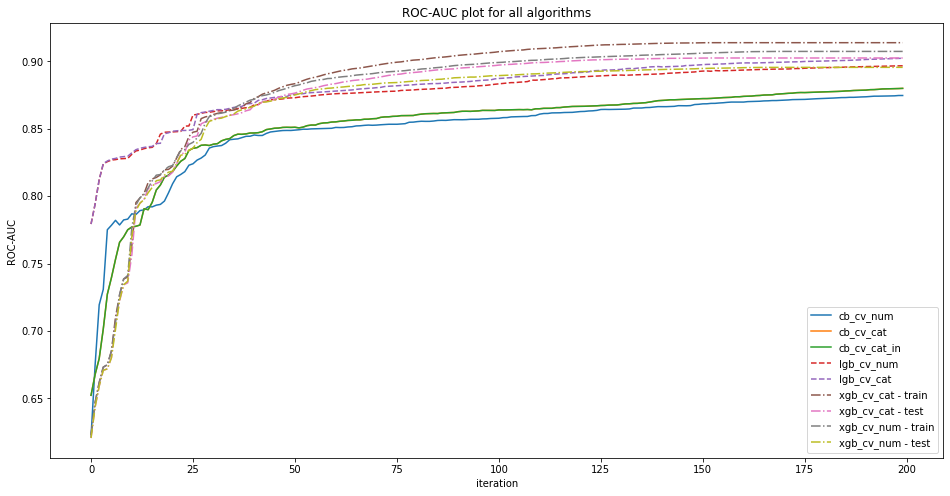

In [20]:
plt.figure(figsize=(16, 8))
plt.title('ROC-AUC plot for all algorithms')

cb_cv_num['test-AUC-mean'].plot(label='cb_cv_num', style='-')
cb_cv_cat['test-AUC-mean'].plot(label='cb_cv_cat', style='-')
cb_cv_cat_in['test-AUC-mean'].plot(label='cb_cv_cat_in', style='-')

lgb_num_cv['auc-mean'].plot(label='lgb_cv_num', style='--')
lgb_cat_cv['auc-mean'].plot(label='lgb_cv_cat', style='--')


xgb_cv_cat['train-auc-mean'].plot(label='xgb_cv_cat - train', style='-.')
xgb_cv_cat['test-auc-mean'].plot(label='xgb_cv_cat - test', style='-.')
xgb_cv_num['train-auc-mean'].plot(label='xgb_cv_num - train', style='-.')
xgb_cv_num['test-auc-mean'].plot(label='xgb_cv_num - test', style='-.')

plt.xlabel('iteration')
plt.ylabel('ROC-AUC')
plt.legend()